In [ ]:
# 變數前處理

%run preprocessing.py
print ("shape of usersXprod :", usersXprod.shape)

p = pd.read_csv("products.csv")
p = p.drop(["product_name"], axis=1)
usersXprod = pd.merge(usersXprod, p, how='left', on=['product_id'])

In [ ]:
# train set convert to form of submit

train_details = ordert[["user_id", "order_id", "product_id", "reordered"]]

try:
    df_train_gt = pd.read_csv('train.csv', index_col='order_id')
except:
    train_gtl = []

    for uid, subset in train_details.groupby('user_id'):
        subset1 = subset[subset.reordered == 1]
        oid = subset.order_id.values[0]

        if len(subset1) == 0:
            train_gtl.append((oid, 'None'))
            continue

        ostr = ' '.join([str(int(e)) for e in subset1.product_id.values])
        # .strip is needed because join can have a padding space at the end
        train_gtl.append((oid, ostr.strip()))

    df_train_gt = pd.DataFrame(train_gtl)

    df_train_gt.columns = ['order_id', 'products']
    df_train_gt.set_index('order_id', inplace=True)
    df_train_gt.sort_index(inplace=True)
    
    df_train_gt.to_csv('train.csv')

In [ ]:
import time

class tick_tock:
    def __init__(self, process_name, verbose=1):
        self.process_name = process_name
        self.verbose = verbose
    def __enter__(self):
        if self.verbose:
            print(self.process_name + " begin ......")
            self.begin_time = time.time()
    def __exit__(self, type, value, traceback):
        if self.verbose:
            end_time = time.time()
            print(self.process_name + " end ......")
            print('time lapsing {0} s \n'.format(end_time - self.begin_time))

# convert to form of submit
def ka_add_groupby_features_n_vs_1(df, group_columns_list, target_columns_list, methods_list, keep_only_stats=True, verbose=1):
    '''Create statistical columns, group by [N columns] and compute stats on [1 column]

       Parameters
       ----------
       df: pandas dataframe
          Features matrix
       group_columns_list: list_like
          List of columns you want to group with, could be multiple columns
       target_columns_list: list_like
          column you want to compute stats, need to be a list with only one element
       methods_list: list_like
          methods that you want to use, all methods that supported by groupby in Pandas

       Return
       ------
       new pandas dataframe with original columns and new added columns

       Example
       -------
       ka_add_stats_features_n_vs_1(train, group_columns_list=['x0'], target_columns_list=['x10'])
    '''
    with tick_tock("add stats features", verbose):
        dicts = {"group_columns_list": group_columns_list , "target_columns_list": target_columns_list, "methods_list" :methods_list}

        for k, v in dicts.items():
            try:
                if type(v) == list:
                    pass
                else:
                    raise TypeError(k + "should be a list")
            except TypeError as e:
                print(e)
                raise

        grouped_name = ''.join(group_columns_list)
        target_name = ''.join(target_columns_list)
        combine_name = [[grouped_name] + [method_name] + [target_name] for method_name in methods_list]

        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)

        the_stats = grouped[target_name].agg(methods_list).reset_index()
        the_stats.columns = [grouped_name] + \
                            ['_%s_%s_by_%s' % (grouped_name, method_name, target_name) \
                             for (grouped_name, method_name, target_name) in combine_name]
        if keep_only_stats:
            return the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new


In [4]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train = usersXprod.loc[usersXprod.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)

X_test = usersXprod.loc[usersXprod.eval_set == "test",:]

X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1),
                                                  train.reordered,
                                                  test_size = 0.9,
                                                  random_state = 42)

#d_train = xgboost.DMatrix(X_train, y_train) # subset
d_train = xgboost.DMatrix(train.drop('reordered', axis=1), train.reordered)

/Users/Shawn/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-logloss:0.625523
[10]	train-logloss:0.334636
[20]	train-logloss:0.267733
[30]	train-logloss:0.250653
[40]	train-logloss:0.246149
[50]	train-logloss:0.244842
[60]	train-logloss:0.244199
[70]	train-logloss:0.243799


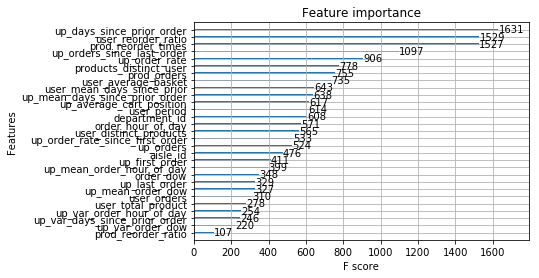

In [5]:
xgb_params = {
    "objective"        : "reg:logistic",
    "eval_metric"      : "logloss",
    "eta"              : 0.1,
    "max_depth"        : 8,
    "min_child_weight" : 10,
    "gamma"            : 0.70,
    "subsample"        : 0.76,
    "colsample_bytree" : 0.95,
    "alpha"            : 2e-05,
    "lambda"           : 10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params = xgb_params,
                    dtrain = d_train,
                    num_boost_round = 80,
                    evals = watchlist,
                    verbose_eval = 10)

xgboost.plot_importance(bst)
plt.show()

> 了解到變數的重要性，如果有變數重要性及啲，那就可以做變數的刪減。

In [6]:
# predict
# convert to the form of submit

d_test = xgboost.DMatrix(X_test.drop(['eval_set', 'user_id', 'order_id', 'reordered', 'product_id'], axis=1))
X_test.loc[:, 'reordered'] = (bst.predict(d_test) > 0.21).astype(int)
X_test.loc[:, 'product_id'] = X_test.product_id.astype(str)

submit = ka_add_groupby_features_n_vs_1(X_test[X_test.reordered == 1], 
                                        group_columns_list = ['order_id'],
                                        target_columns_list = ['product_id'],
                                        methods_list = [lambda x: ' '.join(set(x))],
                                        keep_only_stats = True)
sample_submission = pd.read_csv("sample_submission.csv")
print (len(sample_submission), len(submit))

submit.columns = sample_submission.columns.tolist()
submit_final = sample_submission[['order_id']].merge(submit, how='left').fillna('None')
submit_final.to_csv("submit_xgboost.csv", index = False)

add stats features begin ......
add stats features end ......
time lapsing 5.049909830093384 s 

75000 71308


#### 結果用途：這一次kaggle的比賽主題很清楚，是使用顧客以往的購物資料，去預測下一次消費時他可能會購買的產品。

1. 所以我們這次所做的努力都是希望可以預測精準，如果可以了解到消費者購物的習慣或週期，對於囤貨的管理也可以更有效率，不會有囤貨過多的問題，尤其在生鮮食品的部門更為重要。

2. 針對不同時間的顧客購物商品種類，去調整商品的擺放和促銷的商品的選擇，藉此去增加銷售量。例如：下班時間顧客可能習慣買個菜回家準備晚餐，可能這時候就可以做蔬果的促銷，去增加大家購買的數量之外，以訛傳訛之間也能增加客群。

3. 如果對於賣場商品的相對位置可以蒐集資料加以分析的話，也可以利用物品放置的位置，做隱性的推銷。例如：  
    a. 一般牛奶旁邊放置麵包，可以讓當天為了家裡牛奶沒了的顧客，看到麵包而有興趣，就順便購買。  
    b. 經典的啤酒尿布理論，男士們在週五下班時間會購買啤酒回家，這時候老婆會叮嚀男友順便購買尿布回家。這時候一般人可能會做兩個商品的促銷。  
    但如果利用商品擺放位置分析，我們可以再將商品放置在相對位置，讓顧客必須要走更多的路才能拿到兩個商品，那無形之間也可以增加他亂買東西的機率，增加銷售量。

	